<h2>Image classification via Convolutional Neural Network (CNN)</h2>

<h3>Introduction</h3>The following analysis describes different models 

In this work we investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. Our main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers. These findings were the basis of our ImageNet Challenge 2014 submission, where our team secured the first and the second places in the localisation and classification tracks respectively.

<h3>Data collection</h3><br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.<br>There are 50000 training images and 10000 test images. 
<br><br>
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. <br><br>

<b>DataSet:</b> [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html)


<h3>References:</h3>
    
* Karen Simonyan, Andrew Zisserman:<br>
  <b>Very Deep Convolutional Networks for Large-Scale Image Recognition</b><br>
  [Very Deep Convolutional Networks for Large-Scale Image Recognition][1]<br><br>
    
* Sergey Ioffe, Christian Szegedy<br>
  <b>Batch Normalization</b><br> 
  [Batch Normalization][2]<br><br>
  
* Alex Krizhevsky, 2009<br>
  <b>Learning Multiple Layers of Features from Tiny Images</b><br>
  [Learning Multiple Layers of Features from Tiny Images][3]<br><br>

* ImageNet pretrained Weights<br> 
  [Imagenet][3]<br><br>
    
[1]: https://arxiv.org/abs/1409.1556
[2]: https://arxiv.org/abs/1502.03167 
[3]: https://www.cs.toronto.edu/~kriz/cifar.html
[4]: https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing
    

<h3>Kernel Content</h3>
The current Kernel consists of four separate sections. 

Design patterns as Normalization / Depthwise separable convolutions

- Simple Model to detect images from a CIFAR 10 data set
- Augmented Data Model
- Separable Model 
- Ensamble of models

<b>Batch Normalization</b><br>
Normalization is a wide category of methods to make different samples more similar to each other. This helps a model to learn and generalize much better on new data. The most common form of data normalization centers the data on 0 by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation. 

<b>`normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)`</b>

This makes the assumption that the data follows a normal (or Gaussian) distribution and makes sure this distribution is centered
and scaled to unit variance.

Data normalization should be considered after every transformation operated by the network, even if the data entering a Dense or Conv2D network has a 0 mean and unit variance.

<b>Dropout</b><br>
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly dropping out
(setting to zero) a number of output features of the layer during training.

In [1]:
import keras
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import tensorflow as tf

import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from utils.dataloader import maybe_download_and_extract, get_data_set, Cifar10_DataPreparation
from utils.config import get_config_from_json

c:\applictions\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Definitions 
# ===================================================================

_, config_dict = get_config_from_json('configs/hyperparameters.json')

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = config_dict['cifar']['num_channels']

# Number of classes, one class for each of 10 digits.
num_classes = config_dict['cifar']['num_classes']

# Number of epochs
epochs = config_dict['cifar']['num_epochs']

# Number of max epochs
max_epochs = config_dict['cifar']['maxepochs']

batch_size = config_dict['cifar']['batch_size']

learning_rate = config_dict['cifar']['learning_rate']
learning_rate_decay = config_dict['cifar']['learning_rate_decay']

datashape = (32, 32, 3)

In [3]:
print('Keras: {}'.format(keras.__version__))
print('Tensorflow: {}'.format(tf.VERSION))

matplotlib.style.use('ggplot')

Keras: 2.1.4
Tensorflow: 1.6.0


In [6]:
# load train and test data    
x_train, y_train, x_test, y_test, x_val, y_val = Cifar10_DataPreparation(num_classes)

Train data (40000, 32, 32, 3)
Test data (10000, 32, 32, 3)
Val data (10000, 32, 32, 3)


In [10]:
def plotImages(data, columns = 4, rows = 5):
    
    fig = plt.figure(figsize=(8, 8))
    
    for i in range(1, columns * rows + 1):
        img = np.array(x_train[i])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    

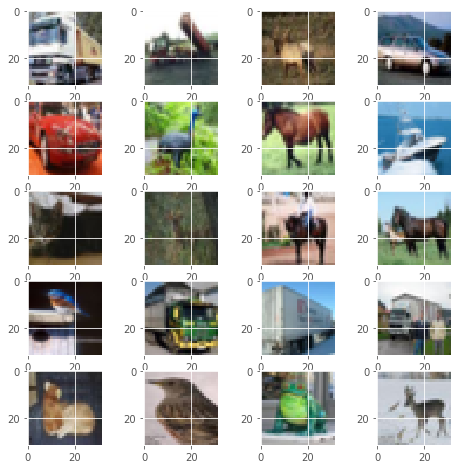

In [8]:
plotImages(x_train, columns = 4, rows = 5)

<h3>General purpose Functions</h3>
This cections contains functions which have been used troughout the Kernal

In [8]:
import datetime

def savemodel(model, filename='mymodel'):
    '''
    Save the model under a given name with a timestamp
    
    Arguments:
    model    - trained model instance
    filename - name of model to store
    
    return:  - filename 
    
    '''
    
    dt = datetime.datetime.now().strftime("%d.%m.%y-%H_%M")
    fname = 'model/weights/' + filename +'_'+ dt + '.h5'
    model.save(fname)
    return fname
       

<h4>Encoding/Decoding (One Hot Vectors)</h4>

In [9]:
def decode(data):
    '''
    Decode one hot encoded array
    
    Arguments: 
    data   - one hot encoded array 
    
    return - int number 
    '''
    return np.argmax(data)

In [10]:
def decodeArray(encoded_data):
    arr = np.array([])
    
    for i in range(encoded_data.shape[0]):
        decoded_item = decode(encoded_data[i])
        arr = np.append(arr, decoded_item)
    
    arr = arr.astype('int32')
    return arr

In [11]:
def encode(data, num_classes):
    '''
    Encode int number to one hot array
    
    Arguments: 
    data   - int number 
    
    return - one hot array 
    '''
    return to_categorical(data, num_classes = num_classes)

<h4>Plot Function</h4>

In [12]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

In [1]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<h3>Callbacks</h3>

When training a model, there are many things you can’t predict from the start. In particular, you can’t tell how many epochs will be needed to get to an optimal validation loss.

A much better way to handle this is to stop training when you measure that the validation loss in no longer improving. This can be achieved using a Keras callback. A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fit and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

In [12]:
def EarlyStopping():
    
    '''
    Define a callback  
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''
    
    callback = EarlyStopping(monitor = 'acc', patience = 1,)
    
    return [callback]

In [13]:
def ReduceLROnPlateau():
    
    '''
    Define a callback  
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''

    callback = ReduceLROnPlateau(monitor  = 'val_loss', 
                                 patience = 10, 
                                 verbose  = 1, 
                                 factor   = 0.1, 
                                 min_lr   = 0.00001)
   
    return [callback]  

In [14]:
def ModelCheckPoint(modelname = 'mymodel.h5'):
    
    '''
    Define a callback checkpoint 
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''
    
    callback = ModelCheckpoint(filepath = modelname,  # model filename
                                 monitor = 'val_loss',   # quantity to monitor
                                 verbose = 0,            # verbosity - 0 or 1
                                 save_best_only = True,  # The latest best model will not be overwritten
                                 mode = 'auto')          # The decision to overwrite model is made 
                                                         # automatically depending on the quantity to monitor
    return [callback]   

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

checkpoint        = ModelCheckPoint(modelname = 'model/weights/modelMNIST.h5')
reducelronplateau = ReduceLROnPlateau()
earlystopping     = EarlyStopping()

In [13]:
def evaluateError(modelname, predicted, y_test):
    res = np.argmax(predicted[0])
    residuals = np.argmax(predicted,1) != np.argmax(y_test, 1)

    loss = 100 * (sum(residuals)/len(residuals))
    text = 'The validation 0/1 loss for ' + modelname +  ' is: '
    print(text, loss, '%')

In [14]:
def evaluateAccuracy(modelname, predicted, y_test):
    res = np.argmax(predicted[0])
    residuals = np.argmax(predicted,1) != np.argmax(y_test, 1)

    loss = sum(residuals)/len(residuals)
    acc = 100 * (1 - loss)
    text = 'The accuracy for ' + modelname + ' is: '
    print(text, acc, '%')

<h3>CIFAR 10 - simple CNN image classification model</h3>
The given model cotains some considerations mentioned in the above mentioned references as Batch Normalization and Dropout
layers. There has no hyper parameter tuning tken place for the given models in this kernel.

In [15]:
def modelSimple(show = True):
    
    model = Sequential()
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape = datashape))  
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(layers.BatchNormalization())  
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))    
    
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(192, (1, 1), activation='relu',padding='valid'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(10, (1, 1), padding='valid'))
    model.add(layers.BatchNormalization())

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(10, activation='softmax'))
    
    if show:
        model.summary()
    
    return model

In [16]:
model = modelSimple(show = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 96)        384       
__________

In [19]:
# reduce the max_epochs to 20 to reduce the training time
max_epochs = 20
model.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

modelname = 'simpleModelCIFAR'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [20]:
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = max_epochs, 
                    validation_data = (x_val, y_val),
                    callbacks= checkpoint,
                    verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 111s 3ms/step - loss: 1.5672 - acc: 0.4475 - val_loss: 1.4390 - val_acc: 0.4958
Epoch 2/20
40000/40000 [==============================] - 107s 3ms/step - loss: 1.0588 - acc: 0.6323 - val_loss: 1.5049 - val_acc: 0.4951
Epoch 3/20
40000/40000 [==============================] - 108s 3ms/step - loss: 0.8639 - acc: 0.6961 - val_loss: 0.9476 - val_acc: 0.6616
Epoch 4/20
40000/40000 [==============================] - 107s 3ms/step - loss: 0.7271 - acc: 0.7487 - val_loss: 0.8820 - val_acc: 0.6956
Epoch 5/20
40000/40000 [==============================] - 107s 3ms/step - loss: 0.6217 - acc: 0.7861 - val_loss: 0.7603 - val_acc: 0.7312
Epoch 6/20
40000/40000 [==============================] - 109s 3ms/step - loss: 0.5430 - acc: 0.8122 - val_loss: 0.8571 - val_acc: 0.7163
Epoch 7/20
40000/40000 [==============================] - 114s 3ms/step - loss: 0.4767 - acc: 0.8377 - val_loss: 0.7708 - 

In [21]:
savemodel(model, 'simpleModelCIFAR')

'model/weights/simpleModelCIFAR_20.05.18-11_43.h5'

In [22]:
# Evaluate the trained model on the test set!

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.13%


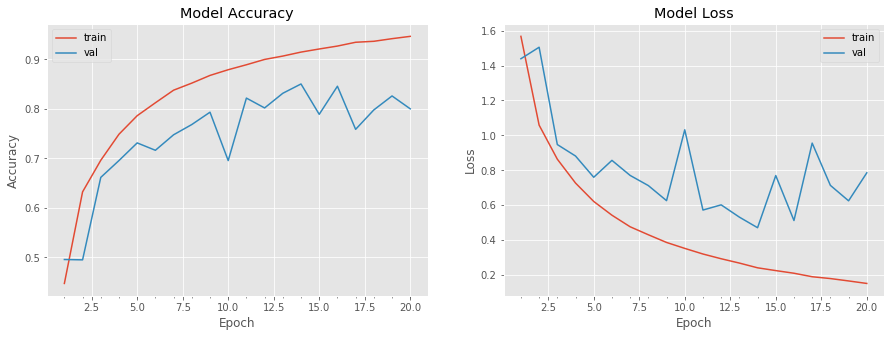

In [23]:
plot_model(history)

The training loss decreases with every epoch, while the training accuracy increases with every epoch. That’s what you would expect when running gradientdescent optimization. The quantity we’re trying to minimize should be less with every iteration. 
In our case that is not what happens for the validation loss and accuracy: They diverge with every additional epoch. 
A model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. 
In precise terms, what you’re seeing is overfitting: after the second epoch, we’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In [18]:
model.load_weights('model/weights/simpleModelCIFAR_20.05.18-11_43.h5')

# Predict 
predicted = model.predict(x_test, batch_size = batch_size, verbose=0)

In [19]:
evaluateError('simpleModelCIFAR', predicted, y_test)

The validation 0/1 loss for simpleModelCIFAR is:  20.87 %


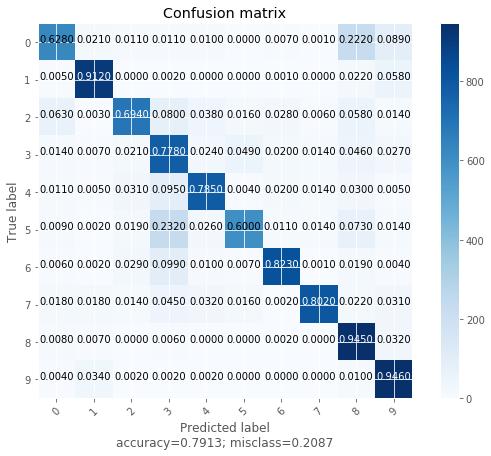

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(decodeArray(y_test), decodeArray(predicted))

plot_confusion_matrix(cm, 
                      target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      title ='Confusion matrix',
                      cmap = None,
                      normalize=True)

<h3>Model with data augmentation</h3>

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model Training a convnet from scratch on a small dataset would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In [26]:
datagen = ImageDataGenerator(featurewise_center = False,             # set input mean to 0 over the dataset
                             samplewise_center = False,              # set each sample mean to 0
                             featurewise_std_normalization = False,  # divide inputs by std of the dataset
                             samplewise_std_normalization = False,   # divide each input by its std
                             zca_whitening = False,                  # apply ZCA whitening
                             rotation_range = 10,                    # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range = 0.2,                # randomly shift images horizontally (fraction of total width)
                             height_shift_range = 0.2,               # randomly shift images vertically (fraction of total height)
                             horizontal_flip = False,                # randomly flip images
                             vertical_flip = False)                  # randomly flip images

datagenerator = datagen.flow(x_train, y_train, batch_size = batch_size)

In [27]:
augmented_model = modelSimple(show = False)

In [29]:
augmented_model.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
maxepochs = 20

modelname = 'simpleAugmentedModelCIFAR'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [30]:
augmented_model_history = augmented_model.fit_generator(datagenerator,
                                                        steps_per_epoch = len(x_train) // batch_size, 
                                                        epochs = maxepochs, 
                                                        validation_data= (x_val, y_val),
                                                        callbacks= checkpoint, 
                                                        verbose=1)

Epoch 1/20
312/312 [==============================] - 107s 344ms/step - loss: 1.6997 - acc: 0.3926 - val_loss: 1.5791 - val_acc: 0.4585
Epoch 2/20
312/312 [==============================] - 107s 343ms/step - loss: 1.2490 - acc: 0.5661 - val_loss: 1.5013 - val_acc: 0.5042
Epoch 3/20
312/312 [==============================] - 106s 341ms/step - loss: 1.0588 - acc: 0.6292 - val_loss: 1.0798 - val_acc: 0.6270
Epoch 4/20
312/312 [==============================] - 107s 342ms/step - loss: 0.9318 - acc: 0.6745 - val_loss: 1.0024 - val_acc: 0.6664
Epoch 5/20
312/312 [==============================] - 111s 356ms/step - loss: 0.8354 - acc: 0.7094 - val_loss: 0.8531 - val_acc: 0.7141
Epoch 6/20
312/312 [==============================] - 112s 360ms/step - loss: 0.7534 - acc: 0.7386 - val_loss: 1.1098 - val_acc: 0.6600
Epoch 7/20
312/312 [==============================] - 113s 362ms/step - loss: 0.6927 - acc: 0.7595 - val_loss: 0.6700 - val_acc: 0.7717
Epoch 8/20
312/312 [============================

In [31]:
savemodel(augmented_model, 'simpleAugmentedModelCIFAR')

'model/weights/simpleAugmentedModelCIFAR_20.05.18-12_26.h5'

In [32]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.13%


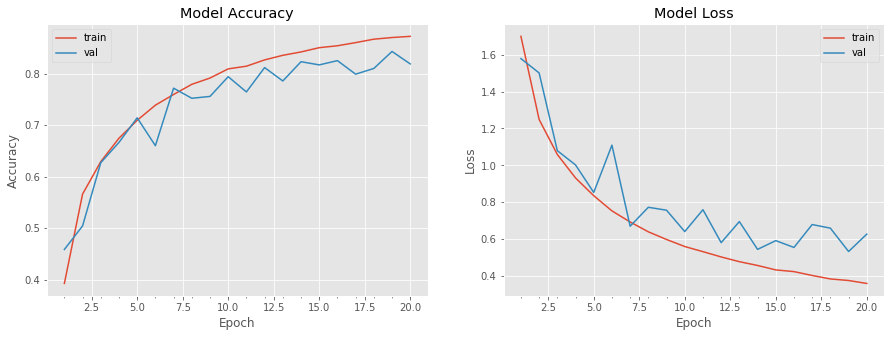

In [33]:
plot_model(augmented_model_history)

The training loss decreases with every epoch, while the training accuracy increases with every epoch. That’s what you would expect when running gradientdescent optimization. The quantity we’re trying to minimize should be less with every iteration. 
We are able to get the overfitting under control (at least a bit), by running the same model as before with data augmentation 
The validation loss and accuracy follow the training validation loss and accuracy much better. 

This would now be the time to start playing around with our hyper parameters (e.g. different optimizer, learning rate, dropout etc.). Hyperparameter tuning is a tideous lengthy process if you need to train 1.4mio params, if you haven't gotten a decent Hardware environment. I'm running on a GPU NVIDIA 960M. It takes about 40 min to train a model on 20 epochs. There is another possible route to follow, which allows lighter models (reduce number of the trainable params).

In [153]:
augmented_model.load_weights('model/weights/simpleAugmentedModelCIFAR_20.05.18-12_26.h5')

# Predict 
predicted = model.predict(x_test, batch_size = batch_size, verbose=0)

In [154]:
evaluateError('simpleAugmentedModelCIFAR', predicted, y_test)

The validation 0/1 loss for simpleAugmentedModelCIFAR is:  17.83 %


<h3>Dephwise separable Convolution</h3>

Dephwise separable Convolution is a layer you can use as a drop-in replacement for Conv2D that will make your model lighter (fewer trainable weight parameters) and faster (fewer floating-point operations).

This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution). This is equivalent to separating the learning of spatial features and the learning of channel-wise features, which makes a lot of sense if you assume that spatial locations in the input are highly correlated, but different channels are fairly independent. It requires significantly fewer parameters and involves fewer computations, thus resulting in smaller, speedier models. 

And because it’s a more representationally efficient way to perform convolution, it tends to learn better representations using less data, resulting in better-performing models.

In [13]:
def modelSimpleSeparable(show = True):
    
    model = Sequential()
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape = datashape))  
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.SeparableConv2D(96, (3, 3), activation='relu', padding = 'same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.SeparableConv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)) 
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(layers.BatchNormalization())
    model.add(layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(layers.Dropout(0.5))    
    
    model.add(layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.SeparableConv2D(192, (1, 1), activation='relu',padding='valid'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    
    if show:
        model.summary()
    
    return model

In [14]:
separableModel = modelSimpleSeparable(show = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 32, 32, 96)        10176     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 16, 16, 96)        10176     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 96)        384       
__________

In [38]:
max_epochs = 20
separableModel.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

modelname = 'simpleSeparableModelCIFAR'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [39]:
separable_history = separableModel.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = max_epochs, 
                    validation_data = (x_val, y_val),
                    callbacks= checkpoint,
                    verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 73s 2ms/step - loss: 1.6113 - acc: 0.4108 - val_loss: 1.8161 - val_acc: 0.4493
Epoch 2/20
40000/40000 [==============================] - 72s 2ms/step - loss: 1.1858 - acc: 0.5749 - val_loss: 1.3347 - val_acc: 0.5676
Epoch 3/20
40000/40000 [==============================] - 72s 2ms/step - loss: 1.0103 - acc: 0.6437 - val_loss: 1.2017 - val_acc: 0.6066
Epoch 4/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.9079 - acc: 0.6775 - val_loss: 1.1020 - val_acc: 0.6410
Epoch 5/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.8315 - acc: 0.7023 - val_loss: 1.0422 - val_acc: 0.6653
Epoch 6/20
40000/40000 [==============================] - 82s 2ms/step - loss: 0.7653 - acc: 0.7296 - val_loss: 0.9580 - val_acc: 0.6858
Epoch 7/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.7163 - acc: 0.7473 - val_loss: 0.7590 - val_acc

In [40]:
# Smodel.save('model/weights/modelSimpleSeparable.h5')
savemodel(separableModel, modelname)

'model/weights/simpleSeparableModelCIFAR_20.05.18-12_55.h5'

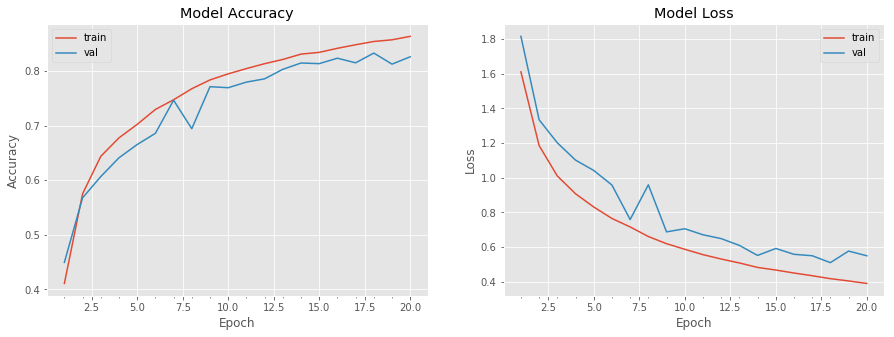

In [41]:
plot_model(separable_history)

In [42]:
scores = separableModel.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.22%


In [155]:
separableModel.load_weights('model/weights/simpleSeparableModelCIFAR_20.05.18-12_55.h5')

# Predict 
predicted = separableModel.predict(x_test, batch_size=batch_size, verbose=0)

In [156]:
evaluateError('modelSimpleSeparable', predicted, y_test)

The validation 0/1 loss for modelSimpleSeparable is:  17.78 %


<h3>Ensemble</h3>

A powerful technique for obtaining the best possible results on a task is model ensembling. Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. The idea behind ensembles is, that different models learn different areas from the data. Combining these models leads usually to a better performance. 

Models used in an ensemble context should not be too similar. 

In [67]:
from keras.models import Model, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average

input_shape = x_train[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [75]:
def CNN_EnsembleModel1(model_input, show = True):
    
    model = Sequential()
    x = layers.Conv2D(96, (3, 3), activation='relu', padding = 'same') (model_input)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.2) (x)
    
    x = layers.SeparableConv2D(96, (3, 3), activation='relu', padding = 'same') (x) 
    x = layers.BatchNormalization() (x)
    x = layers.SeparableConv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2) (x) 
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.5) (x)
    
    x = layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same') (x)  
    x = layers.BatchNormalization() (x)
    x = layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same') (x)
    x = layers.BatchNormalization() (x)
    x = layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2) (x)    
    x = layers.Dropout(0.5) (x)    
    
    x = layers.SeparableConv2D(192, (3, 3), activation='relu', padding = 'same') (x)
    x = layers.BatchNormalization() (x)
    
    x = layers.SeparableConv2D(192, (1, 1), activation='relu',padding='valid') (x)
    x = layers.BatchNormalization() (x)
    
    x = layers.GlobalAveragePooling2D() (x)
    x = layers.Dense(32, activation='relu') (x)
    x = layers.BatchNormalization() (x)
    x = layers.Dense(10, activation='softmax') (x)
    
    model = Model(model_input, x, name='CNN_EnsembleModel1')
        
    if show:
        model.summary()
    
    return model

In [76]:
cnn_ensemblemodel1 = CNN_EnsembleModel1(model_input, show = False)

In [77]:
max_epochs = 20
cnn_ensemblemodel1.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

modelname = 'CNN_EnsembleModel1'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [78]:
cnn_ensemblemodel1_history = cnn_ensemblemodel1.fit(x_train, y_train, 
                                                    batch_size = batch_size,
                                                    epochs = max_epochs, 
                                                    validation_data = (x_val, y_val),
                                                    callbacks= checkpoint,
                                                    verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 76s 2ms/step - loss: 1.6368 - acc: 0.4000 - val_loss: 1.7606 - val_acc: 0.4181
Epoch 2/20
40000/40000 [==============================] - 72s 2ms/step - loss: 1.2214 - acc: 0.5610 - val_loss: 1.2166 - val_acc: 0.5916
Epoch 3/20
40000/40000 [==============================] - 72s 2ms/step - loss: 1.0337 - acc: 0.6293 - val_loss: 1.4053 - val_acc: 0.5603
Epoch 4/20
40000/40000 [==============================] - 72s 2ms/step - loss: 0.9244 - acc: 0.6737 - val_loss: 1.0969 - val_acc: 0.6420
Epoch 5/20
40000/40000 [==============================] - 72s 2ms/step - loss: 0.8385 - acc: 0.7065 - val_loss: 0.8514 - val_acc: 0.7071
Epoch 6/20
40000/40000 [==============================] - 74s 2ms/step - loss: 0.7690 - acc: 0.7295 - val_loss: 0.8867 - val_acc: 0.6964
Epoch 7/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.7095 - acc: 0.7507 - val_loss: 0.7014 - val_acc

In [95]:
savemodel(cnn_ensemblemodel1, 'CNN_EnsembleModel1')

'model/weights/CNN_EnsembleModel1_20.05.18-15_32.h5'

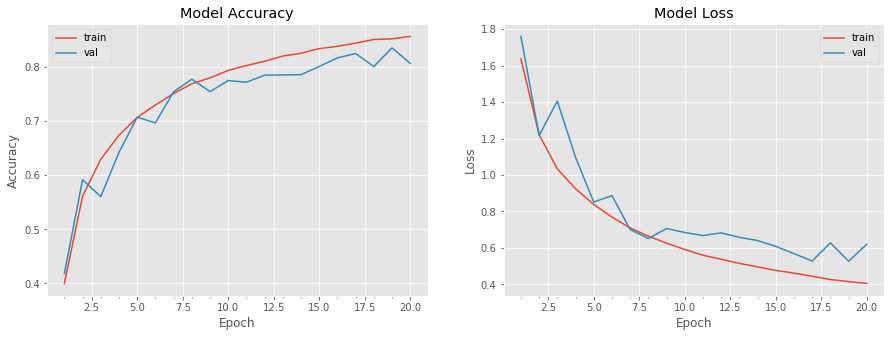

In [99]:
plot_model(cnn_ensemblemodel1_history)

In [79]:
scores = cnn_ensemblemodel1.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.67%


In [80]:
def CNN_EnsembleModel2(model_input, show = True):
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='CNN_EnsembleModel2')
    
    if show:
        model.summary()
        
    return model

In [81]:
cnn_ensemblemodel2 = CNN_EnsembleModel2(model_input, show = False)

In [82]:
max_epochs = 20
cnn_ensemblemodel2.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

modelname = 'CNN_EnsembleModel2'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [83]:
cnn_ensemblemodel2_history = cnn_ensemblemodel1.fit(x_train, y_train, 
                                                    batch_size = batch_size,
                                                    epochs = max_epochs, 
                                                    validation_data = (x_val, y_val),
                                                    callbacks= checkpoint,
                                                    verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.3935 - acc: 0.8619 - val_loss: 0.5029 - val_acc: 0.8343
Epoch 2/20
40000/40000 [==============================] - 74s 2ms/step - loss: 0.3868 - acc: 0.8643 - val_loss: 0.5458 - val_acc: 0.8256
Epoch 3/20
40000/40000 [==============================] - 75s 2ms/step - loss: 0.3764 - acc: 0.8691 - val_loss: 0.5463 - val_acc: 0.8281
Epoch 4/20
40000/40000 [==============================] - 75s 2ms/step - loss: 0.3619 - acc: 0.8727 - val_loss: 0.5288 - val_acc: 0.8316
Epoch 5/20
40000/40000 [==============================] - 74s 2ms/step - loss: 0.3552 - acc: 0.8727 - val_loss: 0.4994 - val_acc: 0.8419
Epoch 6/20
40000/40000 [==============================] - 79s 2ms/step - loss: 0.3447 - acc: 0.8784 - val_loss: 0.5117 - val_acc: 0.8394
Epoch 7/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.3406 - acc: 0.8796 - val_loss: 0.4918 - val_acc

In [84]:
savemodel(cnn_ensemblemodel2, modelname)

'model/weights/CNN_EnsembleModel2_20.05.18-15_04.h5'

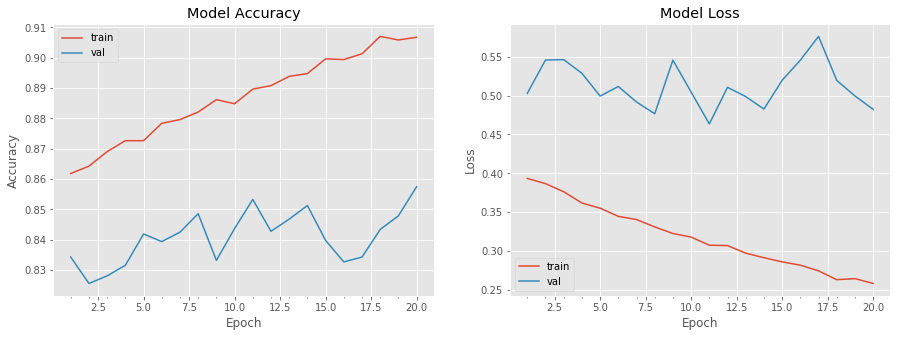

In [100]:
plot_model(cnn_ensemblemodel2_history)

In [85]:
scores = cnn_ensemblemodel2.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 10.01%


In [86]:
def CNN_EnsembleModel3(model_input, show = True):
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
        
    model = Model(model_input, x, name='CNN_EnsembleModel3')
    
    if show:
        model.summary()
        
    return model

In [87]:
cnn_ensemblemodel3 = CNN_EnsembleModel3(model_input, show = False)

In [88]:
max_epochs = 20
cnn_ensemblemodel3.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

modelname = 'CNN_EnsembleModel3'
modelweights = 'model/weights/' + modelname + '.h5'
checkpoint = ModelCheckPoint(modelname = modelweights)

In [89]:
cnn_ensemblemodel3_history = cnn_ensemblemodel1.fit(x_train, y_train, 
                                                    batch_size = batch_size,
                                                    epochs = max_epochs, 
                                                    validation_data = (x_val, y_val),
                                                    callbacks= checkpoint,
                                                    verbose = 1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.2522 - acc: 0.9090 - val_loss: 0.6848 - val_acc: 0.8094
Epoch 2/20
40000/40000 [==============================] - 74s 2ms/step - loss: 0.2489 - acc: 0.9103 - val_loss: 0.5153 - val_acc: 0.8491
Epoch 3/20
40000/40000 [==============================] - 73s 2ms/step - loss: 0.2479 - acc: 0.9122 - val_loss: 0.5578 - val_acc: 0.8384
Epoch 4/20
40000/40000 [==============================] - 74s 2ms/step - loss: 0.2415 - acc: 0.9137 - val_loss: 0.4545 - val_acc: 0.8612
Epoch 5/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.2367 - acc: 0.9153 - val_loss: 0.5036 - val_acc: 0.8504
Epoch 6/20
40000/40000 [==============================] - 72s 2ms/step - loss: 0.2370 - acc: 0.9154 - val_loss: 0.4841 - val_acc: 0.8599
Epoch 7/20
40000/40000 [==============================] - 76s 2ms/step - loss: 0.2290 - acc: 0.9170 - val_loss: 0.4748 - val_acc

In [90]:
savemodel(cnn_ensemblemodel3, modelname)

'model/weights/CNN_EnsembleModel3_20.05.18-15_29.h5'

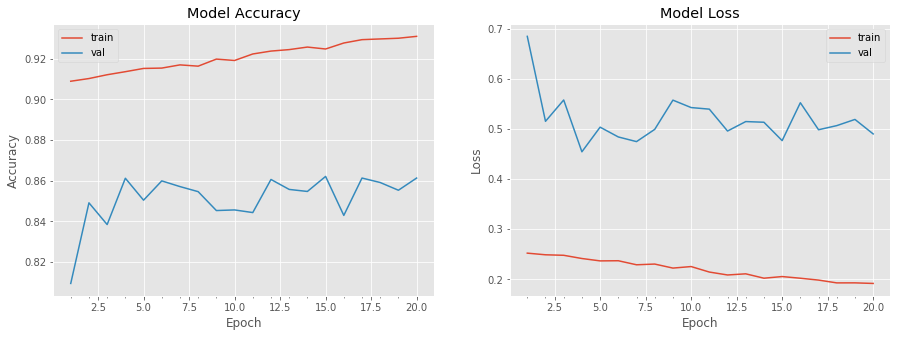

In [101]:
plot_model(cnn_ensemblemodel3_history)

In [91]:
scores = cnn_ensemblemodel3.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 10.00%


In [92]:
def evaluate_error(model):
    pred = model.predict(x_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]  
  
    return error

In [93]:
# Ensemble
from keras.models import Model, Input

def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = layers.Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [158]:
# load pretrained weights with each model

cnn_ensemblemodel1.load_weights('model/weights/CNN_EnsembleModel1_20.05.18-15_32.h5')
cnn_ensemblemodel2.load_weights('model/weights/CNN_EnsembleModel2_20.05.18-15_04.h5')
cnn_ensemblemodel3.load_weights('model/weights/CNN_EnsembleModel3_20.05.18-15_29.h5')

models = [cnn_ensemblemodel1, cnn_ensemblemodel2, cnn_ensemblemodel3]

In [159]:
ensemble_model = ensemble(models, model_input)
evaluate_error(ensemble_model)

8.9327

In [160]:
# Predict 
predicted = ensemble_model.predict(x_test, batch_size=batch_size, verbose=0)

In [161]:
evaluateError('ensemble_model', predicted, y_test)

The validation 0/1 loss for ensemble_model is:  14.77 %


In [162]:
evaluateAccuracy('ensemble_model', predicted, y_test)

The accuracy for ensemble_model is:  85.23 %


As mentioned in the intro of this section, ensamble is a powerful technique for obtaining the best possible results on a task.
The results above show that pooling the 3 models reached the highest accuracy. None of the individual models did get close to to the performance of the ensamble model. 

<h3>Conclusion</h3>